# Master Notebook — Weather- & Risk-Aware Agentic Decision Intelligence (Direction 1)
This notebook reproduces an end-to-end pipeline:

**Dual-stream ViTs (BEiT + MiT-B0)** → **Context/Weather** → **Dynamic Risk** → **IoT Actions** → **Decision-Quality Metrics** → **Ablations**

✅ **All outputs are saved to Google Drive** (figures, tables, logs, JSON exports).


## 1) Setup + Google Drive (all outputs saved to Drive)

In [1]:
# =========================
# 1) Setup + Drive Mount
# =========================
from google.colab import drive
drive.mount('/content/drive')

import os, json, random
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42

# =========================
# GLOBAL CONSTANTS (paper-ready defaults)
# =========================
# Dataset caps (keeps runs feasible on CPU). Increase if you use GPU.
MAX_PEST = 450   # use full pest test set
MAX_CROP = 500   # start small on CPU; try 1000+ on GPU

# Scenario count for decision evaluation
N_SCENARIOS = 800

# Policy / risk thresholds (tunable)
RISK_HIGH = 0.65        # was 0.65
RISK_MED  = 0.40
PENALTY_DELAY = 0.40    # was 0.60 (makes weather-adaptive policy more active)

WEATHER_RAIN_TH = 5
WEATHER_WIND_TH = 5

random.seed(SEED)
np.random.seed(SEED)

# Create an experiment folder on Drive
PROJECT_ROOT = "/content/drive/MyDrive/SmartAgri_Direction1"
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = os.path.join(PROJECT_ROOT, "runs", RUN_ID)

SUBDIRS = ["figures", "tables", "logs", "models", "exports"]
for d in SUBDIRS:
    os.makedirs(os.path.join(RUN_DIR, d), exist_ok=True)

print("RUN_DIR:", RUN_DIR)

def save_fig(name):
    path = os.path.join(RUN_DIR, "figures", name)
    plt.savefig(path, bbox_inches="tight", dpi=200)
    print("Saved:", path)

def save_csv(df, name):
    path = os.path.join(RUN_DIR, "tables", name)
    df.to_csv(path, index=False)
    print("Saved:", path)

def save_json(obj, name):
    path = os.path.join(RUN_DIR, "logs", name)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)
    print("Saved:", path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
RUN_DIR: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409


## 2) Install dependencies

In [2]:
# =========================
# 2) Dependencies
# =========================
!pip -q install transformers timm accelerate datasets evaluate scikit-learn lime

import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# (Optional) record environment info
env_info = {
    "seed": 42,
    "torch_version": torch.__version__,
    "cuda_available": torch.cuda.is_available(),
    "device": DEVICE,
}
save_json(env_info, "environment.json")


Torch: 2.9.0+cpu
CUDA available: False
Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/logs/environment.json


## 3) Data paths (Drive-first)
Put your datasets in Google Drive, e.g.

- `/content/drive/MyDrive/datasets/pests/<class_name>/*.jpg`
- `/content/drive/MyDrive/datasets/crops/<class_name>/*.jpg`


In [3]:
# =========================
# 3) Data Paths (Drive)
# =========================
# You confirmed these folders exist on Google Drive:
#  - /content/drive/MyDrive/Datasets/pest/{train,test}
#  - /content/drive/MyDrive/Datasets/crop/{train,test}
#
# Choose which split to run inference on:
SPLIT = "test"   # "train" or "test" (recommended: "test")

PEST_DATA_DIR = f"/content/drive/MyDrive/Datasets/pest/{SPLIT}"
CROP_DATA_DIR = f"/content/drive/MyDrive/Datasets/crop/{SPLIT}"

import os
assert os.path.isdir(PEST_DATA_DIR), f"PEST_DATA_DIR not found: {PEST_DATA_DIR}"
assert os.path.isdir(CROP_DATA_DIR), f"CROP_DATA_DIR not found: {CROP_DATA_DIR}"
print("Pest dir:", PEST_DATA_DIR)
print("Crop dir:", CROP_DATA_DIR)


Pest dir: /content/drive/MyDrive/Datasets/pest/test
Crop dir: /content/drive/MyDrive/Datasets/crop/test


In [4]:
# =========================
# 3B) Dataset auto-detect (disabled)
# =========================
# You already provided the correct dataset roots in the cell above.
print("[INFO] Using user-provided dataset roots:")
print(" - PEST_DATA_DIR:", PEST_DATA_DIR)
print(" - CROP_DATA_DIR:", CROP_DATA_DIR)


[INFO] Using user-provided dataset roots:
 - PEST_DATA_DIR: /content/drive/MyDrive/Datasets/pest/test
 - CROP_DATA_DIR: /content/drive/MyDrive/Datasets/crop/test


## 4) Load trained checkpoints (recommended)
Set these to your Drive folders where you saved the fine-tuned models.
- `BEIT_CKPT` (pest classifier)
- `MIT_CKPT` (crop classifier)


In [5]:
# =========================
# 4A) Inspect checkpoint folders (debug)
# =========================
import os
from pathlib import Path

def tree(path, max_depth=3):
    path = Path(path)
    if not path.exists():
        print(f"[MISSING] {path}")
        return
    print(f"\n[DIR TREE] {path}")
    base_depth = len(path.parts)
    for p in sorted(path.rglob('*')):
        if len(p.parts) - base_depth > max_depth:
            continue
        rel = p.relative_to(path)
        if p.is_dir():
            continue
        print(' -', rel)

# These vars are defined in the next cell; if you run this cell first,
# re-run it after setting BEIT_CKPT and MIT_CKPT.
try:
    tree(BEIT_CKPT)
    tree(MIT_CKPT)
except NameError:
    print('Run the next cell first to define BEIT_CKPT / MIT_CKPT, then re-run this cell.')


Run the next cell first to define BEIT_CKPT / MIT_CKPT, then re-run this cell.


In [6]:
# =========================
# 4) Locate checkpoints on Drive + robust loading
# =========================
# Your error shows the folder exists but is EMPTY:
#   Folder contents: []
#
# This cell will:
#  1) Print the content of BEIT_CKPT / MIT_CKPT
#  2) Search your Drive for any weights files (*.safetensors, *.bin, *.pt, *.pth, *.ckpt)
#  3) If a valid HuggingFace checkpoint is found, load it
#  4) If nothing is found, it will (optionally) initialize BASE models and SAVE them properly
#     so the pipeline can run end-to-end (baseline/untrained). For real results, you must
#     export your fine-tuned weights from the training notebook.

import os, json, re
from pathlib import Path
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification, ViTImageProcessor

# ✅ Your intended checkpoint folders (case-sensitive)
BEIT_CKPT = "/content/drive/MyDrive/Models/Beit_pests"
MIT_CKPT  = "/content/drive/MyDrive/Models/Mit_crops"

# ✅ Base model IDs (used as fallback)
BEIT_BASE = "microsoft/beit-base-patch16-224"
MIT_BASE  = "nvidia/mit-b0"

WEIGHT_EXTS = (".safetensors", ".bin", ".pt", ".pth", ".ckpt")

def list_dir(path):
    p = Path(path)
    if not p.exists():
        print(f"[MISSING] {path}")
        return []
    items = sorted([x.name for x in p.iterdir()])
    print(f"[DIR] {path} -> {len(items)} item(s)")
    for it in items[:200]:
        print(" -", it)
    if len(items) > 200:
        print(" ...")
    return items

def search_drive_for_weights(root="/content/drive/MyDrive", limit=50):
    root = Path(root)
    hits = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in WEIGHT_EXTS:
            hits.append(str(p))
            if len(hits) >= limit:
                break
    return hits

def _has_any_processor_files(path: str) -> bool:
    candidates = [
        "preprocessor_config.json",
        "image_processor.json",
        "feature_extractor_config.json",
        "processor_config.json",
        "feature_extractor_config.json",
    ]
    return any(os.path.isfile(os.path.join(path, c)) for c in candidates)

def load_image_processor(ckpt_path: str, default_size: int = 224):
    try:
        return AutoImageProcessor.from_pretrained(ckpt_path)
    except Exception as e:
        print(f"[WARN] AutoImageProcessor failed for {ckpt_path}: {e}")
        if not _has_any_processor_files(ckpt_path):
            print("[WARN] No processor config found. Using default ViTImageProcessor (ImageNet stats).")
            return ViTImageProcessor(
                do_resize=True,
                size={"height": default_size, "width": default_size},
                do_rescale=True,
                rescale_factor=1/255,
                do_normalize=True,
                image_mean=[0.485, 0.456, 0.406],
                image_std=[0.229, 0.224, 0.225],
            )
        raise

def is_valid_hf_checkpoint(folder: str) -> bool:
    folder = Path(folder)
    if not folder.exists() or not folder.is_dir():
        return False
    has_cfg = (folder / "config.json").is_file()
    has_weights = any((folder / fn).is_file() for fn in ["model.safetensors", "pytorch_model.bin"])
    # also allow any weights-like file in the folder
    if not has_weights:
        has_weights = any(p.is_file() and p.suffix.lower() in WEIGHT_EXTS for p in folder.iterdir())
    return bool(has_cfg and has_weights)

print("=== Inspect intended checkpoint folders ===")
beit_items = list_dir(BEIT_CKPT)
mit_items  = list_dir(MIT_CKPT)

print("\n=== Searching Drive for any weights files (first 50) ===")
hits = search_drive_for_weights(limit=50)
for h in hits[:50]:
    print(" -", h)
if not hits:
    print("[WARN] No weights files found anywhere under /content/drive/MyDrive")

# Decide what to do
AUTO_CREATE_BASELINE_CHECKPOINTS = True  # set to False if you prefer hard-stop

# If checkpoint folders are invalid/empty, we can auto-create baseline checkpoints
if not is_valid_hf_checkpoint(BEIT_CKPT):
    print(f"\n[WARN] BEIT_CKPT is not a valid HF checkpoint: {BEIT_CKPT}")
    if AUTO_CREATE_BASELINE_CHECKPOINTS:
        print("[INFO] Creating BASELINE (untrained) BEiT checkpoint so the pipeline can run.")
        beit_model = AutoModelForImageClassification.from_pretrained(BEIT_BASE).to(DEVICE).eval()
        beit_processor = AutoImageProcessor.from_pretrained(BEIT_BASE)
        Path(BEIT_CKPT).mkdir(parents=True, exist_ok=True)
        beit_model.save_pretrained(BEIT_CKPT)
        beit_processor.save_pretrained(BEIT_CKPT)
        print("[INFO] Saved baseline BEiT checkpoint to:", BEIT_CKPT)
    else:
        raise FileNotFoundError(
            f"BEIT_CKPT is empty/invalid. Export your trained model with:\n"
            f"  beit_model.save_pretrained('{BEIT_CKPT}')\n"
            f"  beit_processor.save_pretrained('{BEIT_CKPT}')"
        )

if not is_valid_hf_checkpoint(MIT_CKPT):
    print(f"\n[WARN] MIT_CKPT is not a valid HF checkpoint: {MIT_CKPT}")
    if AUTO_CREATE_BASELINE_CHECKPOINTS:
        print("[INFO] Creating BASELINE (untrained) MiT checkpoint so the pipeline can run.")
        mit_model = AutoModelForImageClassification.from_pretrained(MIT_BASE).to(DEVICE).eval()
        mit_processor = AutoImageProcessor.from_pretrained(MIT_BASE)
        Path(MIT_CKPT).mkdir(parents=True, exist_ok=True)
        mit_model.save_pretrained(MIT_CKPT)
        mit_processor.save_pretrained(MIT_CKPT)
        print("[INFO] Saved baseline MiT checkpoint to:", MIT_CKPT)
    else:
        raise FileNotFoundError(
            f"MIT_CKPT is empty/invalid. Export your trained model with:\n"
            f"  mit_model.save_pretrained('{MIT_CKPT}')\n"
            f"  mit_processor.save_pretrained('{MIT_CKPT}')"
        )

# Now load (should work because we ensured valid checkpoints)
beit_processor = load_image_processor(BEIT_CKPT, default_size=224)
mit_processor  = load_image_processor(MIT_CKPT, default_size=224)

beit_model = AutoModelForImageClassification.from_pretrained(BEIT_CKPT).to(DEVICE).eval()
mit_model  = AutoModelForImageClassification.from_pretrained(MIT_CKPT).to(DEVICE).eval()

save_json(
    {"BEIT_CKPT": BEIT_CKPT, "MIT_CKPT": MIT_CKPT, "BEIT_BASE": BEIT_BASE, "MIT_BASE": MIT_BASE,
     "note": "If these are baseline checkpoints, export your fine-tuned checkpoints to replace them."},
    "model_loading_status.json"
)

print("\n✅ Models are ready.")


=== Inspect intended checkpoint folders ===
[DIR] /content/drive/MyDrive/Models/Beit_pests -> 3 item(s)
 - config.json
 - model.safetensors
 - preprocessor_config.json
[DIR] /content/drive/MyDrive/Models/Mit_crops -> 3 item(s)
 - config.json
 - model.safetensors
 - preprocessor_config.json

=== Searching Drive for any weights files (first 50) ===
 - /content/drive/MyDrive/Models/Beit_pests/model.safetensors
 - /content/drive/MyDrive/Models/Mit_crops/model.safetensors


Loading weights:   0%|          | 0/223 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/194 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/logs/model_loading_status.json

✅ Models are ready.


## 5) Inference utilities (save predictions to Drive)

In [7]:
# =========================
# 5) Inference helpers
# =========================
from glob import glob
import numpy as np
from PIL import Image
import os
import torch
import pandas as pd

def list_images(root):
    """
    Recursively list image files under `root`.
    Supports common image extensions in both lower/upper case.
    """
    exts = [
        "*.jpg","*.jpeg","*.png","*.webp","*.bmp","*.tif","*.tiff",
        "*.JPG","*.JPEG","*.PNG","*.WEBP","*.BMP","*.TIF","*.TIFF",
    ]
    files = []
    for e in exts:
        files += glob(os.path.join(root, "**", e), recursive=True)
    return sorted(set(files))


def infer_one(image_path, model, processor):
    img = Image.open(image_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model(**inputs)
        logits = out.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    pred_id = int(np.argmax(probs))
    pred_label = model.config.id2label[pred_id]
    pred_prob = float(probs[pred_id])
    return pred_label, pred_prob


def infer_folder(data_dir, model, processor, name="task", max_images=None, seed=42):
    files = list_images(data_dir)

    if len(files) == 0:
        raise FileNotFoundError(
            f"No images found under: {data_dir}\n"
            "Expected structure: <data_dir>/<class_name>/*.(jpg|png|...)\n"
            "Tip: check Drive path case-sensitivity and file extensions (e.g., .JPG)."
        )

    # Random but reproducible sampling
    if max_images is not None and len(files) > max_images:
        rng = np.random.default_rng(seed)
        idx = rng.choice(len(files), size=max_images, replace=False)
        files = [files[i] for i in idx]

    rows = []
    for fp in files:
        true_label = os.path.basename(os.path.dirname(fp))
        pred_label, pred_prob = infer_one(fp, model, processor)
        rows.append({
            "path": fp,
            "true": true_label,
            "pred": pred_label,
            "pred_prob": pred_prob
        })

    df = pd.DataFrame(rows)
    save_csv(df, f"{name}_predictions.csv")
    return df


print("Inference helpers ready.")



Inference helpers ready.


## 6) Build joint pest–crop scenarios
If you do not have paired CCTV frames (pest+crop observed together), this creates synthetic joint scenarios by sampling predictions.
Later, replace this with true paired observations.

In [8]:
def make_joint_scenarios(pest_pred_df, crop_pred_df, n=800, seed=42):
    """
    Create joint pest–crop scenarios.
    - If you have paired observations, replace this with your pairing logic.
    - This synthetic pairing requires BOTH dataframes to be non-empty.
    """
    if pest_pred_df is None or len(pest_pred_df) == 0:
        raise ValueError("pest_pred_df is empty. Check PEST_DATA_DIR and that images exist under class subfolders.")
    if crop_pred_df is None or len(crop_pred_df) == 0:
        raise ValueError("crop_pred_df is empty. Check CROP_DATA_DIR and that images exist under class subfolders.")

    # Cap n so we don't over-sample too aggressively if datasets are tiny
    n = int(min(n, max(len(pest_pred_df), 1) * 5, max(len(crop_pred_df), 1) * 5))

    pest_rows = pest_pred_df.sample(n=min(len(pest_pred_df), n), replace=True, random_state=seed).to_dict("records")
    crop_rows = crop_pred_df.sample(n=min(len(crop_pred_df), n), replace=True, random_state=seed+1).to_dict("records")

    scenarios = []
    for i in range(n):
        pr = pest_rows[i % len(pest_rows)]
        cr = crop_rows[i % len(crop_rows)]
        scenarios.append({
            "scenario_id": i,
            "pest_true": pr["true"],
            "pest_pred": pr["pred"],
            "pest_prob": pr["pred_prob"],
            "crop_true": cr["true"],
            "crop_pred": cr["pred"],
            "crop_prob": cr["pred_prob"],
        })
    return pd.DataFrame(scenarios)


## 7) Weather/context features
If you do not yet have real weather logs, this simulation produces realistic context variables.
Later, replace this block with API weather readings or on-farm sensors.

In [9]:
# =========================
# 7) Weather/context features
# =========================
def simulate_weather(df, seed=42):
    rng = np.random.default_rng(seed)
    df = df.copy()
    df["temp_c"] = rng.normal(26, 5, size=len(df)).clip(10, 40)
    df["humidity"] = rng.normal(65, 15, size=len(df)).clip(20, 95)
    df["rain_mm"] = rng.gamma(1.5, 3.0, size=len(df))  # skewed
    df["wind_mps"] = rng.normal(2.5, 1.2, size=len(df)).clip(0, 10)
    df["season"] = rng.choice(["spring","summer","autumn","winter"], size=len(df), p=[0.25,0.40,0.25,0.10])
    df["growth_stage"] = rng.choice(["seedling","vegetative","flowering","maturity"], size=len(df), p=[0.20,0.40,0.25,0.15])
    return df


## 8) Dynamic risk scoring + policies (ablation: static vs weather-adaptive)

In [10]:
# =========================
# 8) Dynamic risk + decision policies
# =========================

# NOTE: These dictionaries should match your dataset labels as closely as possible.
# Unknown labels fall back to moderate default values.
BASE_PEST_SEVERITY = {
    "ants": 0.35,
    "earthworms": 0.05,   # beneficial
    "earwig": 0.25,
    "grasshopper": 0.75,
    "moth": 0.70,
    "snail": 0.45,
    "wasp": 0.05,         # beneficial predator
    "weevil": 0.80
}

# If your crop dataset has many classes, keep a fallback default; we also store per-crop values for a subset.
CROP_SENSITIVITY = {
    "jute": 0.60,
    "maize": 0.70,
    "rice": 0.80,
    "sugarcane": 0.75,
    "wheat": 0.65
}

def weather_penalty(temp_c, humidity, rain_mm, wind_mps):
    p = 0.0
    if rain_mm > 5: p += 0.35
    if wind_mps > 5: p += 0.35
    if humidity > 85: p += 0.10
    if temp_c > 35: p += 0.10
    return float(min(1.0, p))

def dynamic_risk(pest_pred, pest_prob, crop_pred, crop_prob,
                 temp_c, humidity, rain_mm, wind_mps, season, growth_stage):
    # Severity/sensitivity priors (fallbacks if labels are unseen)
    s_pest = BASE_PEST_SEVERITY.get(pest_pred, 0.40)
    s_crop = CROP_SENSITIVITY.get(crop_pred, 0.65)

    # Hazard term combines (severity × confidence) for pest and crop
    hazard = (0.55 * s_pest * pest_prob) + (0.25 * s_crop * crop_prob)

    # Context boosts (simple priors; replace with agronomy-based priors later)
    stage_boost = {"seedling": 0.15, "vegetative": 0.10, "flowering": 0.20, "maturity": 0.05}[growth_stage]
    season_boost = {"spring": 0.05, "summer": 0.10, "autumn": 0.05, "winter": 0.00}[season]

    risk_raw = hazard + stage_boost + season_boost
    return float(np.clip(risk_raw, 0, 1))

def policy_static(risk):
    # Use tunable thresholds defined in the first cell.
    if risk >= RISK_HIGH:
        return {"sprayer": True, "irrigation": False, "alert": True, "action": "SPRAY_NOW"}
    elif risk >= RISK_MED:
        return {"sprayer": True, "irrigation": True, "alert": True, "action": "SPRAY_AND_MONITOR"}
    else:
        return {"sprayer": False, "irrigation": True, "alert": True, "action": "MONITOR"}

def policy_weather_adaptive(risk, temp_c, humidity, rain_mm, wind_mps):
    # If weather is unfavorable, delay spraying even when risk is moderate/high.
    penalty = weather_penalty(temp_c, humidity, rain_mm, wind_mps)
    if penalty >= PENALTY_DELAY and risk >= RISK_MED:
        return {"sprayer": False, "irrigation": True, "alert": True, "action": "DELAY_SPRAY_WEATHER"}
    return policy_static(risk)


## 9) Silver-label decision ground truth

In [11]:
# =========================
# 9) Silver-label ground truth for decisions
# =========================
SPRAY_REQUIRED_PESTS = {"grasshopper", "moth", "weevil", "snail"}  # refine per crop

def decision_ground_truth(pest_true, crop_true):
    if pest_true in {"earthworms","wasp"}:
        return 0
    if pest_true in SPRAY_REQUIRED_PESTS:
        return 1
    return 0


## 10) Run pipeline + decision-quality metrics (saved to Drive)

In [12]:
# =========================
# 9B) DATASET SANITY CHECK (important)
# =========================
from pathlib import Path

def count_images(root):
    root = Path(root)
    if not root.exists():
        return 0
    exts = {'.jpg','.jpeg','.png','.webp','.bmp','.tif','.tiff'}
    return sum(1 for p in root.rglob('*') if p.is_file() and p.suffix.lower() in exts)

def list_classes(root, max_classes=30):
    root = Path(root)
    if not root.exists():
        return []
    classes = sorted([p.name for p in root.iterdir() if p.is_dir()])
    return classes[:max_classes]

print('SPLIT:', SPLIT)
print('PEST_DATA_DIR:', PEST_DATA_DIR)
print('CROP_DATA_DIR:', CROP_DATA_DIR)

pest_n = count_images(PEST_DATA_DIR)
crop_n = count_images(CROP_DATA_DIR)
print('Pest images found:', pest_n)
print('Crop images found:', crop_n)
print('Pest classes (sample):', list_classes(PEST_DATA_DIR))
print('Crop classes (sample):', list_classes(CROP_DATA_DIR))

assert pest_n > 0, 'No pest images found. Check folder structure and extensions.'
assert crop_n > 0, 'No crop images found. Check folder structure and extensions.'


SPLIT: test
PEST_DATA_DIR: /content/drive/MyDrive/Datasets/pest/test
CROP_DATA_DIR: /content/drive/MyDrive/Datasets/crop/test
Pest images found: 450
Crop images found: 6627
Pest classes (sample): ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']
Crop classes (sample): ['Aji pepper plant', 'Almonds plant', 'Amaranth plant', 'Apples plant', 'Artichoke plant', 'Avocados plant', 'Bananas plant', 'Barley plant', 'Beets plant', 'Black pepper plant', 'Blueberries plant', 'Bok choy plant', 'Brazil nuts plant', 'Broccoli plant', 'Brussels sprout plant', 'Buckwheat plant', 'Cabbages and other brassicas plant', 'Camucamu plant', 'Carrots and turnips plant', 'Cashew nuts plant', 'Cassava plant', 'Cauliflower plant', 'Celery plant', 'Cherimoya plant', 'Cherry plant', 'Chestnuts plant', 'Chickpeas plant', 'Chili peppers and green peppers plant', 'Cinnamon plant', 'Cloves plant']


In [13]:
# =========================
# 10) Run pipeline + metrics + ablation (paper-ready)
# =========================
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# --- 10A) Inference (capped for CPU feasibility)
pest_pred_df = infer_folder(PEST_DATA_DIR, beit_model, beit_processor, name="pest", max_images=MAX_PEST, seed=SEED)
crop_pred_df = infer_folder(CROP_DATA_DIR, mit_model, mit_processor, name="crop", max_images=MAX_CROP, seed=SEED)

print("pest_pred_df:", pest_pred_df.shape)
print("crop_pred_df:", crop_pred_df.shape)

# --- 10B) Joint scenarios + context
scenarios = make_joint_scenarios(pest_pred_df, crop_pred_df, n=N_SCENARIOS, seed=SEED)
scenarios = simulate_weather(scenarios, seed=SEED)

# --- 10C) Policies + dataset for analysis
records = []
for r in scenarios.to_dict("records"):
    risk = dynamic_risk(
        r["pest_pred"], r["pest_prob"],
        r["crop_pred"], r["crop_prob"],
        r["temp_c"], r["humidity"], r["rain_mm"], r["wind_mps"],
        r["season"], r["growth_stage"]
    )
    dec_static = policy_static(risk)
    dec_adapt  = policy_weather_adaptive(risk, r["temp_c"], r["humidity"], r["rain_mm"], r["wind_mps"])

    gt_spray = decision_ground_truth(r["pest_true"], r["crop_true"])

    records.append({
        **r,
        "risk": risk,
        "gt_spray": int(gt_spray),
        "static_sprayer": int(dec_static["sprayer"]),
        "static_action": dec_static["action"],
        "adapt_sprayer": int(dec_adapt["sprayer"]),
        "adapt_action": dec_adapt["action"],
        "weather_penalty": weather_penalty(r["temp_c"], r["humidity"], r["rain_mm"], r["wind_mps"])
    })

out = pd.DataFrame(records)
save_csv(out, "decision_dataset_with_policies.csv")

# --- 10D) Decision-quality metrics
def decision_metrics(gt, pred):
    gt = np.asarray(gt)
    pred = np.asarray(pred)
    return {
        "accuracy": float((gt == pred).mean()),
        "precision": float(precision_score(gt, pred, zero_division=0)),
        "recall": float(recall_score(gt, pred, zero_division=0)),
        "f1": float(f1_score(gt, pred, zero_division=0)),
        "spray_rate": float(pred.mean())
    }

gt = out["gt_spray"].values
static_pred = out["static_sprayer"].values
adapt_pred  = out["adapt_sprayer"].values

m_static = decision_metrics(gt, static_pred)
m_adapt  = decision_metrics(gt, adapt_pred)

unnecessary_static = int(((static_pred == 1) & (gt == 0)).sum())
unnecessary_adapt  = int(((adapt_pred == 1) & (gt == 0)).sum())
reduction = (unnecessary_static - unnecessary_adapt) / max(1, unnecessary_static)

summary = pd.DataFrame([
    {"policy":"static", **m_static, "unnecessary_sprays": unnecessary_static},
    {"policy":"weather_adaptive", **m_adapt, "unnecessary_sprays": unnecessary_adapt, "unnecessary_reduction": float(reduction)}
])
save_csv(summary, "decision_quality_summary.csv")

# --- 10E) Confusion matrices (decision level) saved as CSV
cm_static = confusion_matrix(gt, static_pred, labels=[0,1])
cm_adapt  = confusion_matrix(gt, adapt_pred,  labels=[0,1])

cm_df = pd.DataFrame(
    [
        {"policy":"static", "TN": int(cm_static[0,0]), "FP": int(cm_static[0,1]), "FN": int(cm_static[1,0]), "TP": int(cm_static[1,1])},
        {"policy":"weather_adaptive", "TN": int(cm_adapt[0,0]),  "FP": int(cm_adapt[0,1]),  "FN": int(cm_adapt[1,0]),  "TP": int(cm_adapt[1,1])},
    ]
)
save_csv(cm_df, "decision_confusion_matrices.csv")

summary


Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/tables/pest_predictions.csv
Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/tables/crop_predictions.csv
pest_pred_df: (450, 4)
crop_pred_df: (500, 4)
Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/tables/decision_dataset_with_policies.csv
Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/tables/decision_quality_summary.csv
Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/tables/decision_confusion_matrices.csv


,policy,accuracy,precision,recall,f1,spray_rate,unnecessary_sprays,unnecessary_reduction
0,static,0.8025,0.196429,0.244444,0.217822,0.140,90,NaN
1,weather_adaptive,0.8050,0.194444,0.233333,0.212121,0.135,87,0.033333


## 11) Plot: Unnecessary sprays vs weather penalty (saved to Drive)

Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/figures/risk_score_distribution.png


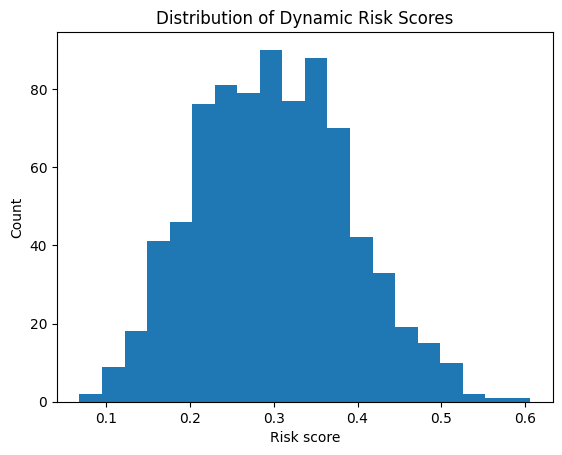

/tmp/ipython-input-3230370203.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp2 = out.groupby(bins).apply(lambda df: pd.Series({


Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/figures/spray_rate_vs_weather_penalty.png


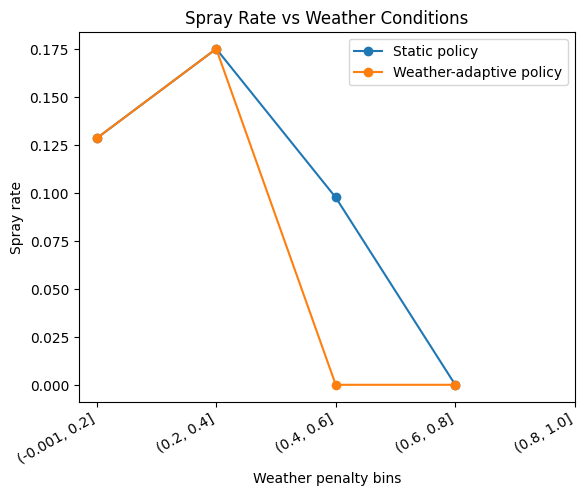

Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/tables/spray_rate_by_weather_penalty.csv
Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/tables/policy_metrics_table.csv
Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/figures/policy_metrics_curves.png


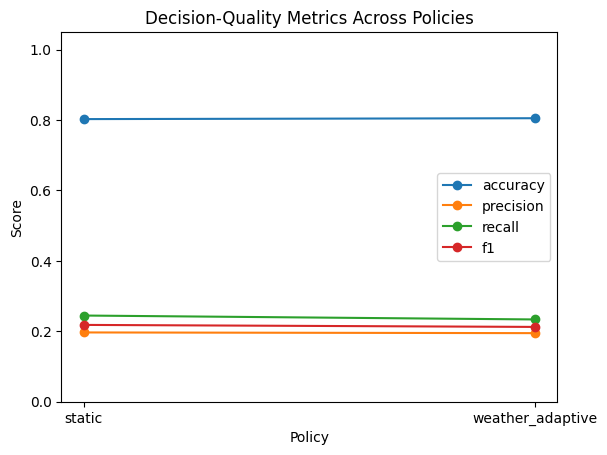

Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/tables/top_predicted_pests.csv
Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/tables/top_predicted_crops.csv
Saved extra analysis artifacts.


In [14]:
# =========================
# 10F) Extra figures + tables for "Results & Discussion"
# =========================
# Produces:
#  - Risk distribution (hist)
#  - Spray rate by weather penalty bin (curve)
#  - Policy metrics curves (accuracy/precision/recall/F1)
#  - Top predicted classes tables (pest/crop)
# All saved to Google Drive under RUN_DIR.

import numpy as np

# --- (1) Risk distribution
plt.figure()
plt.hist(out["risk"].values, bins=20)
plt.xlabel("Risk score")
plt.ylabel("Count")
plt.title("Distribution of Dynamic Risk Scores")
save_fig("risk_score_distribution.png")
plt.show()

# --- (2) Spray rate vs penalty bins
bins = pd.cut(out["weather_penalty"], bins=[0,0.2,0.4,0.6,0.8,1.0], include_lowest=True)
tmp2 = out.groupby(bins).apply(lambda df: pd.Series({
    "static_spray_rate": float(df["static_sprayer"].mean()),
    "adapt_spray_rate": float(df["adapt_sprayer"].mean()),
    "count": len(df)
})).reset_index()

plt.figure()
x = np.arange(len(tmp2))
plt.plot(x, tmp2["static_spray_rate"], marker="o", label="Static policy")
plt.plot(x, tmp2["adapt_spray_rate"], marker="o", label="Weather-adaptive policy")
plt.xticks(x, [str(b) for b in tmp2[bins.name]], rotation=30, ha="right")
plt.xlabel("Weather penalty bins")
plt.ylabel("Spray rate")
plt.legend()
plt.title("Spray Rate vs Weather Conditions")
save_fig("spray_rate_vs_weather_penalty.png")
plt.show()

save_csv(tmp2, "spray_rate_by_weather_penalty.csv")

# --- (3) Policy metrics curves
metrics_cols = ["accuracy", "precision", "recall", "f1"]
mplot = summary[["policy"] + metrics_cols].copy()
save_csv(mplot, "policy_metrics_table.csv")

plt.figure()
x = np.arange(len(mplot))
for col in metrics_cols:
    plt.plot(x, mplot[col].values, marker="o", label=col)
plt.xticks(x, mplot["policy"].values, rotation=0)
plt.ylim(0, 1.05)
plt.xlabel("Policy")
plt.ylabel("Score")
plt.legend()
plt.title("Decision-Quality Metrics Across Policies")
save_fig("policy_metrics_curves.png")
plt.show()

# --- (4) Top predicted classes tables
top_pest = pest_pred_df["pred"].value_counts().reset_index()
top_pest.columns = ["predicted_pest", "count"]
save_csv(top_pest, "top_predicted_pests.csv")

top_crop = crop_pred_df["pred"].value_counts().reset_index()
top_crop.columns = ["predicted_crop", "count"]
save_csv(top_crop, "top_predicted_crops.csv")

print("Saved extra analysis artifacts.")


In [15]:
# =========================
# OPTIONAL: Stratified sampling for crop inference (balanced evaluation subset)
# =========================
# If your crop dataset is extremely large, sample up to K images per class.
from pathlib import Path

def stratified_file_sample(root, k_per_class=20, seed=42):
    root = Path(root)
    rng = np.random.default_rng(seed)
    exts = {'.jpg','.jpeg','.png','.webp','.bmp','.tif','.tiff'}
    files = []
    for cls_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        cls_files = [p for p in cls_dir.rglob("*") if p.is_file() and p.suffix.lower() in exts]
        if len(cls_files) == 0:
            continue
        k = min(k_per_class, len(cls_files))
        idx = rng.choice(len(cls_files), size=k, replace=False)
        files.extend([str(cls_files[i]) for i in idx])
    rng.shuffle(files)
    return files

# Example:
# files = stratified_file_sample(CROP_DATA_DIR, k_per_class=10, seed=SEED)
# print("Sampled files:", len(files))


/tmp/ipython-input-2736015475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = out.groupby(bins).apply(lambda df: pd.Series({


Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/figures/unnecessary_sprays_vs_weather_penalty.png


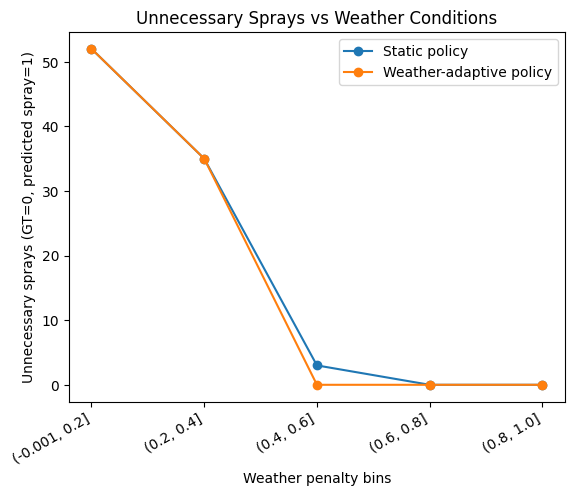

Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/tables/unnecessary_sprays_by_weather_penalty.csv


In [16]:
# =========================
# 11) Plot saved to Drive
# =========================
plt.figure()
bins = pd.cut(out["weather_penalty"], bins=[0,0.2,0.4,0.6,0.8,1.0], include_lowest=True)

tmp = out.groupby(bins).apply(lambda df: pd.Series({
    "static_unnecessary": int(((df["static_sprayer"]==1) & (df["gt_spray"]==0)).sum()),
    "adapt_unnecessary": int(((df["adapt_sprayer"]==1) & (df["gt_spray"]==0)).sum()),
    "count": len(df)
})).reset_index()

x = np.arange(len(tmp))
plt.plot(x, tmp["static_unnecessary"], marker="o", label="Static policy")
plt.plot(x, tmp["adapt_unnecessary"], marker="o", label="Weather-adaptive policy")
plt.xticks(x, [str(b) for b in tmp[bins.name]], rotation=30, ha="right")
plt.xlabel("Weather penalty bins")
plt.ylabel("Unnecessary sprays (GT=0, predicted spray=1)")
plt.legend()
plt.title("Unnecessary Sprays vs Weather Conditions")
save_fig("unnecessary_sprays_vs_weather_penalty.png")
plt.show()

save_csv(tmp, "unnecessary_sprays_by_weather_penalty.csv")


## 12) Export decision JSON for LLM explanations (saved to Drive)

In [17]:
# =========================
# 12) Export decision JSON for LLM stage
# =========================
K = 20
sample_cases = out.sample(K, random_state=SEED).to_dict("records")

decision_json = []
for c in sample_cases:
    decision_json.append({
        "scenario_id": int(c["scenario_id"]),
        "predicted_pest": c["pest_pred"],
        "pest_confidence": float(c["pest_prob"]),
        "predicted_crop": c["crop_pred"],
        "crop_confidence": float(c["crop_prob"]),
        "context": {
            "temp_c": float(c["temp_c"]),
            "humidity": float(c["humidity"]),
            "rain_mm": float(c["rain_mm"]),
            "wind_mps": float(c["wind_mps"]),
            "season": c["season"],
            "growth_stage": c["growth_stage"],
        },
        "risk_score": float(c["risk"]),
        "policy_outputs": {
            "static": {"sprayer": bool(c["static_sprayer"]), "action": c["static_action"]},
            "weather_adaptive": {"sprayer": bool(c["adapt_sprayer"]), "action": c["adapt_action"]},
        }
    })

save_json(decision_json, "llm_decision_cases.json")
print("Exported", len(decision_json), "cases for LLM explanations.")


Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/logs/llm_decision_cases.json
Exported 20 cases for LLM explanations.


## ✅ Outputs
All artifacts are saved under:

`/content/drive/MyDrive/SmartAgri_Direction1/runs/<RUN_ID>/`

- `figures/` → plots (PNG)
- `tables/` → CSV results
- `logs/` → JSON configs and exports


Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/figures/cm_static.png


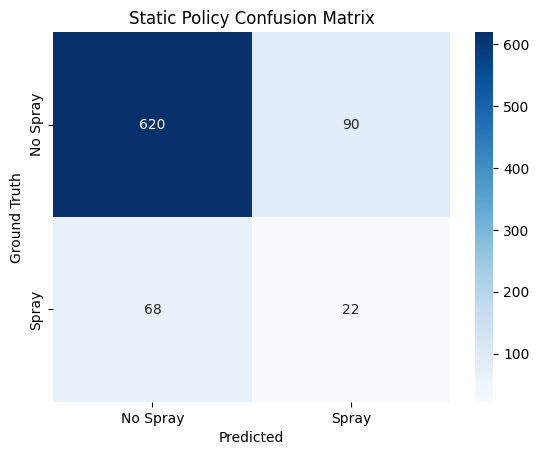

Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/figures/cm_adaptive.png


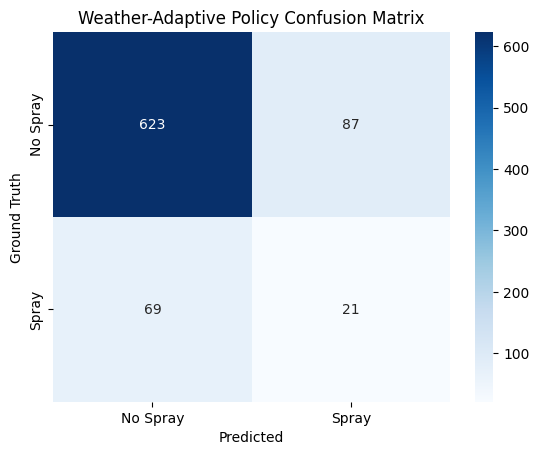

In [18]:
import seaborn as sns

def plot_confusion(cm, title, fname):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Spray","Spray"],
                yticklabels=["No Spray","Spray"])
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.title(title)
    save_fig(fname)
    plt.show()

plot_confusion(cm_static, "Static Policy Confusion Matrix",
               "cm_static.png")

plot_confusion(cm_adapt, "Weather-Adaptive Policy Confusion Matrix",
               "cm_adaptive.png")


Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/figures/decision_boundary_risk.png


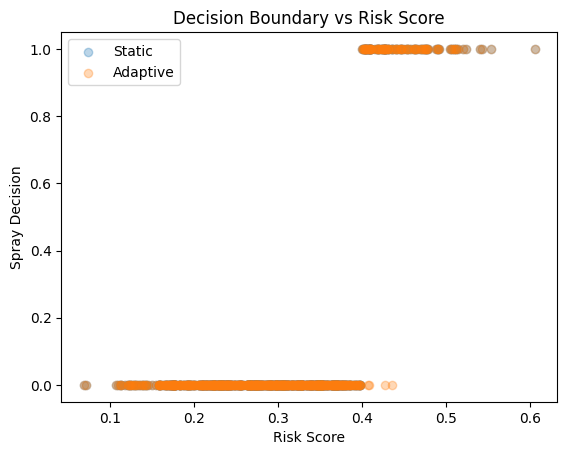

In [19]:
plt.figure()
plt.scatter(out["risk"], out["static_sprayer"], alpha=0.3, label="Static")
plt.scatter(out["risk"], out["adapt_sprayer"], alpha=0.3, label="Adaptive")
plt.xlabel("Risk Score")
plt.ylabel("Spray Decision")
plt.legend()
plt.title("Decision Boundary vs Risk Score")
save_fig("decision_boundary_risk.png")
plt.show()


In [20]:
policy_table = summary.copy()
policy_table["spray_reduction_%"] = (
    100 * (summary.loc[0,"spray_rate"] - summary.loc[1,"spray_rate"])
)
save_csv(policy_table, "policy_comparison_table.csv")
policy_table


Saved: /content/drive/MyDrive/SmartAgri_Direction1/runs/20260209_002409/tables/policy_comparison_table.csv


,policy,accuracy,precision,recall,f1,spray_rate,unnecessary_sprays,unnecessary_reduction,spray_reduction_%
0,static,0.8025,0.196429,0.244444,0.217822,0.140,90,NaN,0.5
1,weather_adaptive,0.8050,0.194444,0.233333,0.212121,0.135,87,0.033333,0.5
